In [1]:
%load_ext autoreload
%autoreload 2

import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals, rms
from MDAnalysis.lib.distances import calc_dihedrals 

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
import pandas as pd
import math
import sys
import os
import seaborn as sns
import torch

import molann.ann as ann 
from molann.feature import Feature

# This line is used to find the package. 
# It may need to be modified. 
sys.path.append('../colvars-finder/')

from colvarsfinder.utils import WeightedTrajectory
from colvarsfinder.nn import EigenFunctions, AutoEncoder, RegAutoEncoder
from colvarsfinder.core import EigenFunctionTask, AutoEncoderTask, RegAutoEncoderTask

### Set parameters 

In [3]:
# name of topology file
topology_filename = './top.gro' 

# the data is prepared from previous simulation. 
traj_filename = './md_center.xtc' 

u = mda.Universe(topology_filename, traj_filename)

print ('Number of residues: %d' % len(u.residues)) 

Number of residues: 3


### Load trajectory data 

In [4]:
for res_id in range(len(u.residues)):
    res = u.residues[res_id]
    atom_selected = res.phi_selection()
    if atom_selected is not None:
        df = pd.DataFrame(list(zip(atom_selected.ids, atom_selected.names, atom_selected.types)), columns = ['id', 'name', 'type'])
        print ('residual %d, phi dihedral angle:' % (res_id+1) )
        print (df, '\n')
    atom_selected = res.psi_selection()
    if atom_selected is not None:
        df = pd.DataFrame(list(zip(atom_selected.ids, atom_selected.names, atom_selected.types)), columns = ['id', 'name', 'type'])
        print ('residual %d, psi dihedral angle:' % (res_id+1) )
        print (df, '\n')
        
time_list = np.linspace(u.trajectory.time, u.trajectory.totaltime, u.trajectory.n_frames) * 1e-3

# print some information
print ('%d residues: ' % len(u.residues), u.residues, '\n')
print ('trajectory: ', u.trajectory, '\n')
print ('time of trajectory (in ps) , range [%.1f, %.1f], dt=%.1f\n' % (u.trajectory.time, u.trajectory.totaltime, u.trajectory.dt))

residual 2, phi dihedral angle:
   id name type
0   5    C    C
1   7    N    N
2   9   CA    C
3  15    C    C 

residual 2, psi dihedral angle:
   id name type
0   7    N    N
1   9   CA    C
2  15    C    C
3  17    N    N 

3 residues:  <ResidueGroup [<Residue ACE, 1>, <Residue ALA, 2>, <Residue NME, 3>]> 

trajectory:  <XTCReader ./md_center.xtc with 150001 frames of 22 atoms> 

time of trajectory (in ps) , range [0.0, 1500000.0], dt=10.0



### Compute dihedral angles along trajectory

In [5]:
selector = 'resid 2'
atom_selected = u.select_atoms(selector)

r = dihedrals.Ramachandran(atom_selected).run()

cv_names = ['phi', 'psi']
dihedrals_df = pd.DataFrame(r.results.angles[:,0,:], columns=cv_names)
dihedrals_df['t'] = time_list

print ('dihedral angles:\n', dihedrals_df.describe())

traj_angles = r.results.angles[:,0,:]

dihedral angles:
                  phi            psi              t
count  150001.000000  150001.000000  150001.000000
mean      -95.604094      89.797716     750.000000
std        39.789746      87.437963     433.017032
min      -179.906774    -179.999613       0.000000
25%      -127.377640       5.031059     375.000000
50%       -90.068527     139.192875     750.000000
75%       -72.135193     156.528747    1125.000000
max       179.923482     179.998821    1500.000000


### Before training, plot some figures of the data 

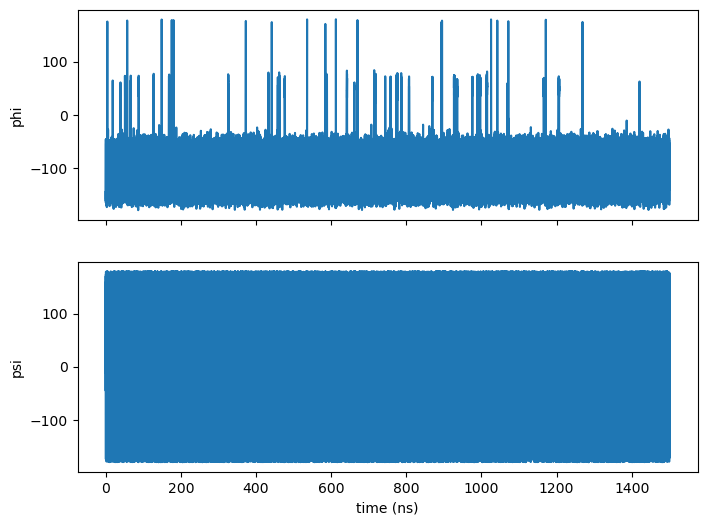

(-180.0, 180.0)

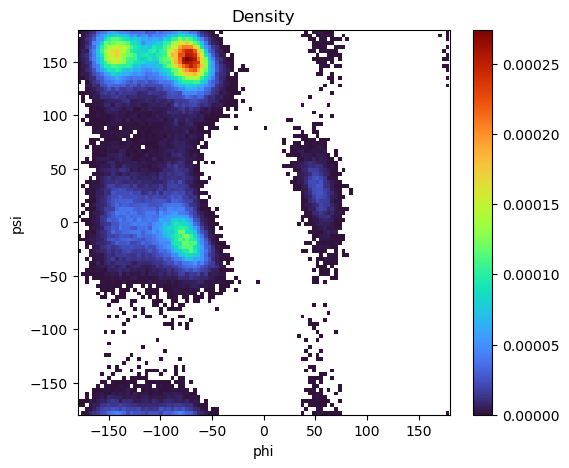

In [7]:
f, axarr = plt.subplots(2, figsize=(8,6), sharex=True)
sns.lineplot(dihedrals_df, x='t', y=cv_names[0], ax=axarr[0])
sns.lineplot(dihedrals_df, x='t', y=cv_names[1], ax=axarr[1])
axarr[1].set_xlabel('time (ns)')
plt.show()
 
plt.figure(figsize=(6,5))   

sns.histplot(data=dihedrals_df, x=cv_names[0], y=cv_names[1], cbar=True, stat='density', cmap='turbo', bins=(100,100))
plt.title('Density')
plt.xlim(-180, 180)
plt.ylim(-180, 180)

### Set parameters for training
 See https://colvars-finder.readthedocs.io/en/latest/core.html for requires parameters

In [23]:
batch_size = 20000
num_epochs = 100
test_ratio = 0.2
learning_rate = 0.002
optimizer_name = 'Adam'

# learn the first two eigenfunctions
k=2
# unit: ns
lag_tau = 0.01
alpha = 20
eig_weights = [1.0, 0.2]

activation = torch.nn.Tanh

align_selector = 'type C or type O or type N'
input_selector = 'type C or type O or type N'

### Build a (preprocessing) neural network layer that is invariant under rotation and translation. 
Here we make use of the small package **molann** : https://molann.readthedocs.io/en/latest/index.html

In [9]:
# 10 non-hydrogen atoms
input_ag = u.select_atoms(input_selector)

feature_list = [Feature('p1', 'position', input_ag)]

feature_mapper = ann.FeatureLayer(feature_list, input_ag)

print ('\nFeatures in preprocessing layer:')
# display information of features used 
print (feature_mapper.get_feature_info())

align_atom_group = u.select_atoms(align_selector)

align = ann.AlignmentLayer(align_atom_group, input_ag)
align.show_info()

pp_layer = ann.PreprocessingANN(align, feature_mapper)


Features in preprocessing layer:
  name      type  type_id                         atom indices
0   p1  position        3  [2, 5, 6, 7, 9, 11, 15, 16, 17, 19]

10 atoms used for input, (0-based) global indices: 
 [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]

10 atoms used for alignment, with (0-based) global indices: 
 [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]
local indices
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

positions of reference state used in aligment:
 [[-2.7460003  -2.047001    0.8839989 ]
 [-1.276001   -1.8370008   0.6539993 ]
 [-0.4960022  -2.7070007   0.8639984 ]
 [-0.90600014 -0.6570015   0.08399963]
 [ 0.40399933 -0.18700123 -0.39600182]
 [ 0.70399857 -0.56700134 -1.8860016 ]
 [ 0.6039982   1.2429981  -0.19600105]
 [-0.34600067  2.0229988  -0.3260002 ]
 [ 1.8740005   1.6630001   0.0739994 ]
 [ 2.184       3.072998    0.24399757]]


### Prepare trajectory, model and training task

In [24]:
# load the trajectory data
traj_obj = WeightedTrajectory(u, input_ag) 

# input layer has dimension 30, as we use coordiates of 10 nonhydrogen atoms as input
# we learn the first two eigenfunctions 
model = EigenFunctions([30,20,20,20,1], 2)

train_obj = EigenFunctionTask(traj_obj, pp_layer, model,  model_path='training-output', \
                              alpha=alpha, eig_weights=eig_weights, save_model_every_step=0,\
                              lag_tau=lag_tau, learning_rate=0.001, k=2, \
                              batch_size=batch_size, num_epochs=num_epochs, optimizer_name=optimizer_name)    


loading trajectory to numpy array...done.

Trajectory Info:
  no. of frames in trajectory data: 150001
  time of first frame: 0.0ps
  time of last frame: 1500000.0ps
  stepsize: 10.0ps
  time length: 1500000.0ps
  shape of trajectory data array: (150001, 10, 3)


[Info] Log directory: training-output


Eigenfunctions:
 EigenFunctions(
  (eigen_funcs): ModuleList(
    (0): Sequential(
      (1): Linear(in_features=30, out_features=20, bias=True)
      (activation 1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (activation 2): Tanh()
      (3): Linear(in_features=20, out_features=20, bias=True)
      (activation 3): Tanh()
      (4): Linear(in_features=20, out_features=1, bias=True)
    )
    (1): Sequential(
      (1): Linear(in_features=30, out_features=20, bias=True)
      (activation 1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (activation 2): Tanh()
      (3): Linear(in_features=20, out_features=20, bias=True)
      (

In [ ]:
# Uncommnet this cell to train autoencoder

# input layer has dimension 30, as we use coordiates of 10 nonhydrogen atoms as input
#model = AutoEncoder([30,20,20,20,2], [2,10,10,30])

#train_obj = AutoEncoderTask(traj_obj, pp_layer, model,  model_path='training-output', \
#                            learning_rate=0.001, batch_size=batch_size, \
#                            num_epochs=num_epochs, optimizer_name=optimizer_name, save_model_every_step=0)    

In [ ]:
# Uncommnet this cell to train a regularized autoencoder

# input layer has dimension 30, as we use coordiates of 10 nonhydrogen atoms as input
# we learn autoencoder and use the first two eigenfunctions as regularizers
#model = RegAutoEncoder([30,20,20,20,2], [2,10,10,30], [2,10,10,1], 2)

#train_obj = RegAutoEncoderTask(traj_obj, pp_layer, model,  model_path='training-output', \
#                               eig_weights=eig_weights, alpha=1.0, gamma=[1.0, 10.0], \
#                               lag_tau_ae=0, lag_tau_reg=0.01, \
#                                learning_rate=0.001, batch_size=batch_size, \
#                                num_epochs=num_epochs, optimizer_name=optimizer_name, save_model_every_step=0)  

## train the model

In [25]:
train_obj.train()


Training starts.
100 epochs in total, batch sizes (train/test): 20000/20000

Train set:
	120000 data, 6 iterations per epoch, 600 iterations in total.
Test set:
	30000 data, 1 iterations per epoch, 100 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.14s/it]


###  plot loss and the learned eigenfunctions

<AxesSubplot: ylabel='loss'>

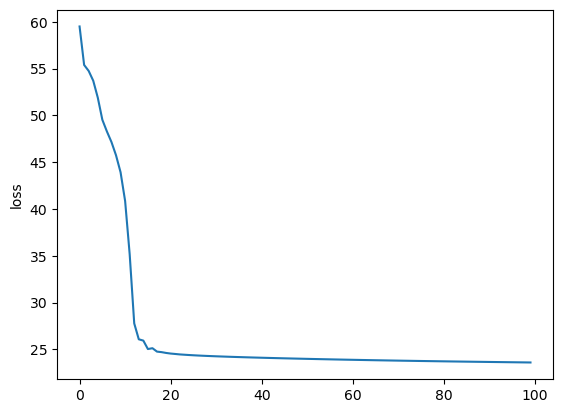

In [26]:
sns.lineplot(train_obj.train_loss_df, x=train_obj.train_loss_df.index, y='loss')

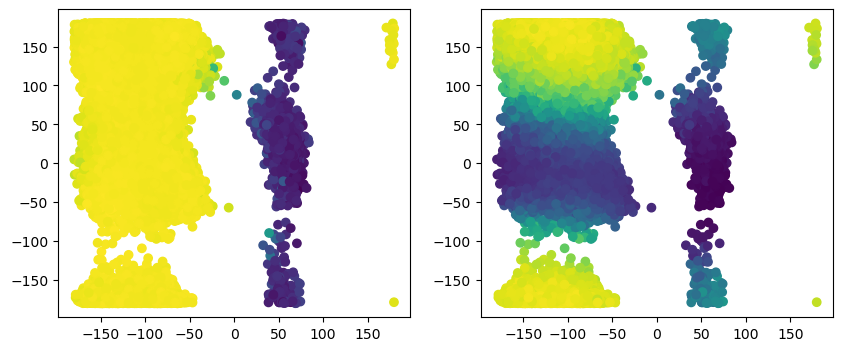

In [27]:
# get the model and evaluate on data
model=train_obj.colvar_model()
cv_ts = model(torch.tensor(traj_obj.trajectory)).detach().numpy()

fig, ax=plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(dihedrals_df['phi'], dihedrals_df['psi'], c=cv_ts[:,0])
ax[1].scatter(dihedrals_df['phi'], dihedrals_df['psi'], c=cv_ts[:,1])
plt.show()